In [2]:
import uproot 
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, ReLU
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from xgboost import XGBClassifier

2023-02-16 13:29:28.022532: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/fermilab.opensciencegrid.org/products/common/db/../prd/ifdhc/v2_6_10/Linux64bit-3-10-2-17/lib:/mu2e/app/users/myucel/mu2e-dev/build/sl7-prof-e20-p037/Offline/lib:/cvmfs/mu2e.opensciencegrid.org/artexternals/cryptopp/v08_02_00/Linux64bit+3.10-2.17-e20-prof:/cvmfs/mu2e.opensciencegrid.org/artexternals/gcc/v9_3_0/Linux64bit+3.10-2.17/lib64:/cvmfs/mu2e.opensciencegrid.org/artexternals/gcc/v9_3_0/Linux64bit+3.10-2.17/lib:/cvmfs/fermilab.opensciencegrid.org/products/common/db/../prd/curl/v7_64_1/Linux64bit-3-10/lib:/cvmfs/mu2e.opensciencegrid.org/artexternals/cry/v1_7p/Linux64bit+3.10-2.17-e20-prof/cry_v1.7/lib:/cvmfs/mu2e.opensciencegrid.org/artexternals/KinKal/v02_03_01/slf7.x86_64.e20.p3913.prof/lib:/cvmfs/mu2e.opensciencegrid.or

In [3]:
input_dataset = np.empty
temp = np.empty
signal = np.empty
backgnd = np.empty
#filelist = os.environ['KKTrainBkgFiles']
filelist = "KKTrainBkgFiles.txt"
print("Using files in " + filelist)
files = open(filelist, 'r')
for filename in files:
    print("Processing: " + filename)    
    with uproot.open(filename) as file:
        bkgdiag = file["BD"]["bkgcdiag"].arrays()
        bkgdiag = bkgdiag[(bkgdiag['mvastat']>0)&((bkgdiag['pproc']==167)|(bkgdiag['pproc']<20))]
        clusterrho = bkgdiag['ClusterRho'].to_numpy()
        zmin = bkgdiag['ZMin'].to_numpy()
        zmax = bkgdiag['ZMax'].to_numpy()
        zgap = bkgdiag['ZGap'].to_numpy()
        nplanes = bkgdiag['NPlanes'].to_numpy()
        planefraction = bkgdiag['PlaneFraction'].to_numpy()
        nhits = bkgdiag['NHits'].to_numpy()
        pproc = bkgdiag['pproc'].to_numpy()
        #print("Processed file " + filename + " with %s hits"%hstate.shape[0])
        print("Processed file " + filename + " with %s hits"%nhits.shape[0])
        temp = np.vstack((clusterrho, zmin, zmax, zgap, nplanes, planefraction, nhits)).T
        if input_dataset is np.empty:
            input_dataset = temp
        else:
            input_dataset = np.concatenate((input_dataset, temp))
        sig = pproc<20
        bkg = pproc==167
        if signal is np.empty:
            signal = sig
            backgnd = bkg
        else:
            signal = np.concatenate((signal,sig))
            backgnd = np.concatenate((backgnd,bkg))
nclusters=len(input_dataset)
nsignal=signal.sum()
nbackgnd=backgnd.sum()
print("Total dataset %s hits, %s signal and %s background"%(nhits,nsignal,nbackgnd))

Using files in KKTrainBkgFiles.txt
Processing: /pnfs/mu2e/scratch/users/myucel/BkgDiag10k.root
Processed file /pnfs/mu2e/scratch/users/myucel/BkgDiag10k.root with 329247 hits
Total dataset [ 5. 10. 11. ...  5.  4.  4.] hits, 280088 signal and 49159 background


In [5]:
min_len = min(len(input_dataset[signal]), len(input_dataset[backgnd]))
bsize=32
# I need to double the batch_size when truncating as we divide the sample in half later for training
tsize=2*bsize
min_len = min_len - min_len%tsize
print("Training on %s matched hits"%min_len)
signal_dataset = input_dataset[signal][:min_len]
bkg_dataset = input_dataset[backgnd][:min_len]

balanced_input = np.concatenate((signal_dataset, bkg_dataset))
y_balanced_input = np.concatenate((np.ones(signal_dataset.shape[0]), np.zeros(bkg_dataset.shape[0])))

n_variables = balanced_input.shape[1]

x_ce_train, x_ce_test, y_ce_train, y_ce_test = train_test_split(balanced_input, y_balanced_input, test_size=0.5, random_state=42)
x_ce_test, x_ce_valid, y_ce_test, y_ce_valid = train_test_split(x_ce_test, y_ce_test, test_size=0.5, random_state=42)

Training on 49152 matched hits


In [6]:
clusterrho_sig = []
zmin_sig = []
zmax_sig = []
zgap_sig = []
nplanes_sig = []
planefraction_sig = []
nhits_sig = []

for i in range(signal_dataset.shape[0]):
    clusterrho_sig.append(signal_dataset[i][0])
    
for i in range(signal_dataset.shape[0]):
    zmin_sig.append(signal_dataset[i][1])
    
for i in range(signal_dataset.shape[0]):
    zmax_sig.append(signal_dataset[i][2])

for i in range(signal_dataset.shape[0]):
    zgap_sig.append(signal_dataset[i][3])
    
for i in range(signal_dataset.shape[0]):
    nplanes_sig.append(signal_dataset[i][4])

for i in range(signal_dataset.shape[0]):
    planefraction_sig.append(signal_dataset[i][5])

for i in range(signal_dataset.shape[0]):
    nhits_sig.append(signal_dataset[i][6])

In [7]:
clusterrho_back = []
zmin_back = []
zmax_back = []
zgap_back = []
nplanes_back = []
planefraction_back = []
nhits_back = []

for i in range(bkg_dataset.shape[0]):
    clusterrho_back.append(bkg_dataset[i][0])
    
for i in range(bkg_dataset.shape[0]):
    zmin_back.append(bkg_dataset[i][1])
    
for i in range(bkg_dataset.shape[0]):
    zmax_back.append(bkg_dataset[i][2])

for i in range(bkg_dataset.shape[0]):
    zgap_back.append(bkg_dataset[i][3])

for i in range(bkg_dataset.shape[0]):
    nplanes_back.append(bkg_dataset[i][4])
    
for i in range(bkg_dataset.shape[0]):
    planefraction_back.append(bkg_dataset[i][5])
    
for i in range(bkg_dataset.shape[0]):
    nhits_back.append(bkg_dataset[i][6])

<function matplotlib.pyplot.show(close=None, block=None)>

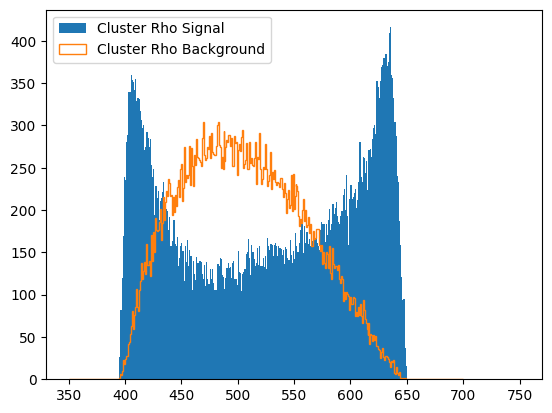

In [8]:
plt.hist(clusterrho_sig,label="Cluster Rho Signal", bins=400,range=(350,750))
plt.hist(clusterrho_back,label="Cluster Rho Background", histtype='step', bins=400,range=(350,700))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

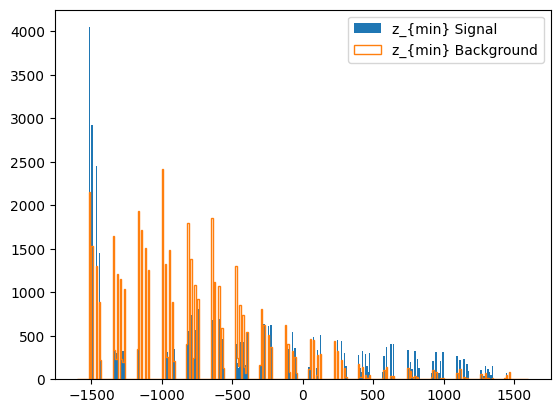

In [9]:
plt.hist(zmin_sig,label="z_{min} Signal", bins=320,range=(-1600.0,1600.0))
plt.hist(zmin_back,label="z_{min} Background", histtype='step', bins=320, range=(-1600.0,1600.0))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

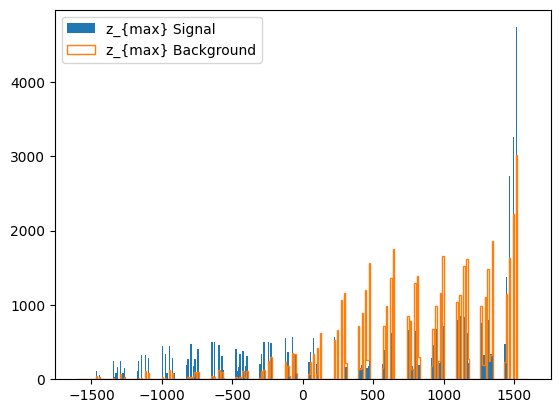

In [10]:
plt.hist(zmax_sig,label="z_{max} Signal", bins=320,range=(-1600.0,1600.0))
plt.hist(zmax_back,label="z_{max} Background", histtype='step', bins=320, range=(-1600.0,1600.0))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

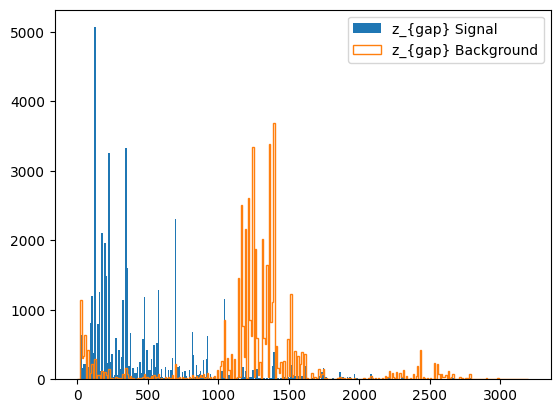

In [11]:
plt.hist(zgap_sig,label="z_{gap} Signal", bins=320,range=(0.0,3200.0))
plt.hist(zgap_back,label="z_{gap} Background", histtype='step', bins=320, range=(0.0,3200.0))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

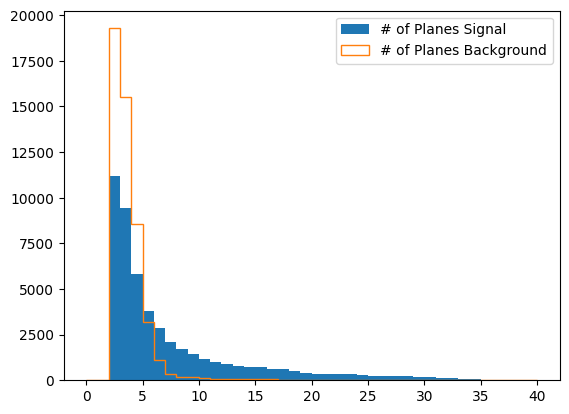

In [12]:
plt.hist(nplanes_sig,label="# of Planes Signal",bins=40,range=(0,40.0))
plt.hist(nplanes_back,label="# of Planes Background", histtype='step', bins=40, range=(0,40.0))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

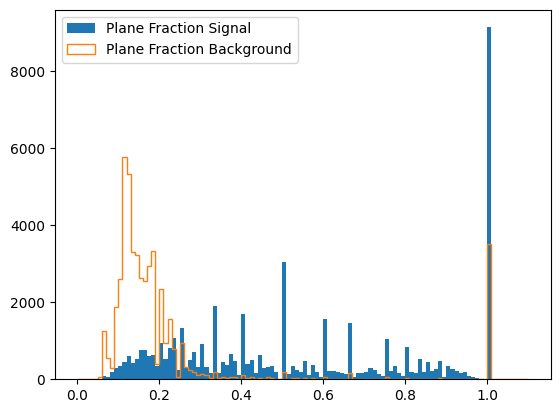

In [13]:
plt.hist(planefraction_sig,label="Plane Fraction Signal", bins=110, range=(0,1.1))
plt.hist(planefraction_back,label="Plane Fraction Background", histtype='step', bins=110, range=(0,1.1))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

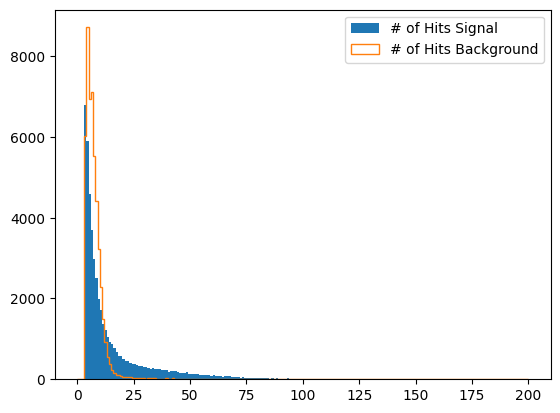

In [14]:
plt.hist(nhits_sig,label="# of Hits Signal", bins=200, range=(0.0,200.0))
plt.hist(nhits_back,label="# of Hits Background", histtype='step', bins=200, range=(0.0,200.0))
plt.legend()
plt.show

In [15]:
lay0=Input(shape=(n_variables,),batch_size=1)
lay1=Dense(2*n_variables, activation='relu')(lay0)
lay2=Dense(2*n_variables, activation='relu')(lay1)
lay3=Dense(2*n_variables, activation='relu')(lay2)
lay4=Dense(1,activation='sigmoid')(lay3)
output_model=Model(inputs=lay0,outputs=lay4)

opt = Adam(learning_rate=1e-3)
input=Input(shape=(n_variables,),batch_size=bsize)
x=Dense(2*n_variables, activation='relu')(input)
x=Dense(2*n_variables, activation='relu')(x)
x=Dense(2*n_variables, activation='relu')(x)
output=Dense(1,activation='sigmoid')(x)
model_ce=Model(inputs=input,outputs=output)
model_ce.compile(loss='binary_crossentropy',metrics='accuracy',optimizer=opt)
early_stop = EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-5, restore_best_weights=True)
history_ce = model_ce.fit(x_ce_train, y_ce_train,
                          batch_size=bsize,
                          epochs=200,
                          verbose=1,
                          validation_data=(x_ce_valid, y_ce_valid),
                          callbacks=[early_stop]
                         )

2023-02-16 13:31:54.564366: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/fermilab.opensciencegrid.org/products/common/db/../prd/ifdhc/v2_6_10/Linux64bit-3-10-2-17/lib:/mu2e/app/users/myucel/mu2e-dev/build/sl7-prof-e20-p037/Offline/lib:/cvmfs/mu2e.opensciencegrid.org/artexternals/cryptopp/v08_02_00/Linux64bit+3.10-2.17-e20-prof:/cvmfs/mu2e.opensciencegrid.org/artexternals/gcc/v9_3_0/Linux64bit+3.10-2.17/lib64:/cvmfs/mu2e.opensciencegrid.org/artexternals/gcc/v9_3_0/Linux64bit+3.10-2.17/lib:/cvmfs/fermilab.opensciencegrid.org/products/common/db/../prd/curl/v7_64_1/Linux64bit-3-10/lib:/cvmfs/mu2e.opensciencegrid.org/artexternals/cry/v1_7p/Linux64bit+3.10-2.17-e20-prof/cry_v1.7/lib:/cvmfs/mu2e.opensciencegrid.org/artexternals/KinKal/v02_03_01/slf7.x86_64.e20.p3913.prof/lib:/cvmfs/mu2e.opensciencegrid.org/arte

Epoch 1/200
1536/1536 [==============================] - 7s 2ms/step - loss: 1.3673 - accuracy: 0.8175 - val_loss: 0.6000 - val_accuracy: 0.8555
Epoch 2/200
1536/1536 [==============================] - 3s 2ms/step - loss: 0.5091 - accuracy: 0.8461 - val_loss: 0.4768 - val_accuracy: 0.8563
Epoch 3/200
1536/1536 [==============================] - 3s 2ms/step - loss: 0.4403 - accuracy: 0.8568 - val_loss: 0.3930 - val_accuracy: 0.8613
Epoch 4/200
1536/1536 [==============================] - 3s 2ms/step - loss: 0.4105 - accuracy: 0.8617 - val_loss: 0.3837 - val_accuracy: 0.8725
Epoch 5/200
1536/1536 [==============================] - 3s 2ms/step - loss: 0.3870 - accuracy: 0.8664 - val_loss: 0.3320 - val_accuracy: 0.8787
Epoch 6/200
1536/1536 [==============================] - 3s 2ms/step - loss: 0.3625 - accuracy: 0.8707 - val_loss: 0.4443 - val_accuracy: 0.8463
Epoch 7/200
1536/1536 [==============================] - 3s 2ms/step - loss: 0.3508 - accuracy: 0.8747 - val_loss: 0.3238 - val_ac

In [16]:
model_xgboost = XGBClassifier()
model_xgboost.fit(x_ce_train, y_ce_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [17]:
#prediction_ce = model_ce.predict(x_ce_test).ravel()
prediction_ce = model_ce.predict(x_ce_test)
fpr_ce, tpr_ce, th_ce = roc_curve(y_ce_test,  prediction_ce)
auc_ce = roc_auc_score(y_ce_test, prediction_ce)

768/768 [==============================] - 1s 974us/step


In [18]:
prediction_xgboost = model_xgboost.predict_proba(x_ce_test)[:,1]
fpr_xgboost, tpr_xgboost, th_xgboost = roc_curve(y_ce_test,  prediction_xgboost)
auc_xgboost = roc_auc_score(y_ce_test, prediction_xgboost)

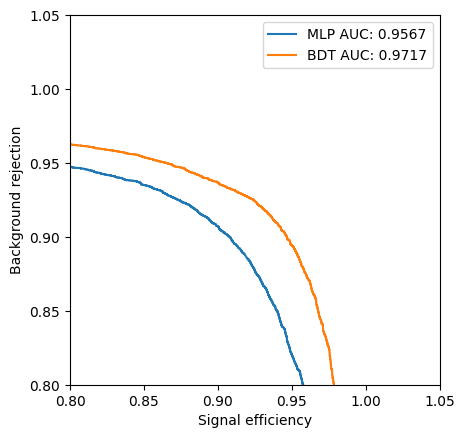

In [19]:
fig, ax = plt.subplots(1,1)
ax.plot(tpr_ce,1-fpr_ce,label=f'MLP AUC: {auc_ce:.4f}')
ax.plot(tpr_xgboost,1-fpr_xgboost,label=f'BDT AUC: {auc_xgboost:.4f}')

ax.legend()
ax.set_aspect("equal")
ax.set_xlabel("Signal efficiency")
ax.set_ylabel("Background rejection")
ax.set_xlim(0.8,1.05)
ax.set_ylim(0.8,1.05)
fig.savefig("TrainBkgDiag.pdf")

In [20]:
output_model.set_weights(model_ce.get_weights())
output_model.summary()
output_model.save("TrainBkgDiag.h5")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(1, 7)]                  0         
                                                                 
 dense (Dense)               (1, 14)                   112       
                                                                 
 dense_1 (Dense)             (1, 14)                   210       
                                                                 
 dense_2 (Dense)             (1, 14)                   210       
                                                                 
 dense_3 (Dense)             (1, 1)                    15        
                                                                 
Total params: 547
Trainable params: 547
Non-trainable params: 0
_________________________________________________________________
